
# Adjusting Incidence for Positive Rate

## Load and Prepare Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from copy import copy

In [2]:
# supress annoying warnings for plotting
warnings.filterwarnings('ignore')

In [3]:
# load data [30Mb!]
full_data = pd.read_csv('owid-full_data.csv')
# docu at: https://github.com/owid/covid-19-data/tree/master/public/data
# 100k rows, 60 cols

# convert date variable to pd.Timestamp object
full_data.date = pd.to_datetime(full_data.date)

In [4]:
# Extract Relevant Columns 
cases_icu = full_data[['location',  'date', 'new_cases_smoothed_per_million', 'positive_rate',
                               'icu_patients_per_million', 'people_fully_vaccinated_per_hundred',
                               'weekly_icu_admissions_per_million']]

In [5]:
# extract floats and location
floats = cases_icu.dtypes == 'float64'
floats_names = np.append(cases_icu.columns.values[floats.values], 'location')
subdf_floats = cases_icu[floats_names]

### Normalize Curves to [0,1]

In [6]:
transformed_cases_icu = subdf_floats.groupby('location').transform(lambda col: ((col - col.min())) / (col.max() - col.min()))
# compute positive rate to incidence ratio on normalized data
pr2in_ratio = transformed_cases_icu.positive_rate/transformed_cases_icu.new_cases_smoothed_per_million
cases_icu.insert(loc=1, column='pr2in_ratio', value=pr2in_ratio)

# or use individual columns
# cases_icu.insert(loc=1, column='norm_posrate', value=transformed_cases_icu.positive_rate)
# cases_icu.insert(loc=1, column='norm_incidence', value=transformed_cases_icu.new_cases_smoothed_per_million)

## Correct Incidence for Positive Rate and Group by Country

### Compute Adjusted Incidence

In [7]:
# Add Column for adjusted Incidence
# Parameterize influence of Positive Rate
alpha = 1.3
# Account for posrate above given threshold
threshold = 2.5
# Add baseline factor to scale values
baseline_factor = 5**alpha

adj_incidence = cases_icu['new_cases_smoothed_per_million']*(cases_icu['positive_rate']*100)**alpha
cases_icu.insert(loc=0, column='adj_incidence', value=adj_incidence)

psm1 = [(row.adj_incidence if row.pr2in_ratio > threshold else row.new_cases_smoothed_per_million*baseline_factor) for _, row in cases_icu.iterrows()]
cases_icu.insert(loc=1, column='psm1', value=psm1)

# Group by Country
cases_icu_grouped = cases_icu.groupby('location')

In [8]:
# Get names of locations/ countries for which ICU data is available
icu_admissions_countries = []
icu_countries = []

for location, group in cases_icu_grouped:
    if not group['weekly_icu_admissions_per_million'].isnull().values.all():
        icu_admissions_countries.append(location)
    if not group['icu_patients_per_million'].isnull().values.all():
        icu_countries.append(location)
        
print('Weekly ICU-Admissions available for: \n', icu_admissions_countries, '\n')
print('ICU-Patients (on a given day) available for: \n', icu_countries)

Weekly ICU-Admissions available for: 
 ['Cyprus', 'Czechia', 'Estonia', 'France', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Latvia', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'] 

ICU-Patients (on a given day) available for: 
 ['Algeria', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Romania', 'Singapore', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']


## Plot Results: Correlation with ICU <u> Admissions </u>

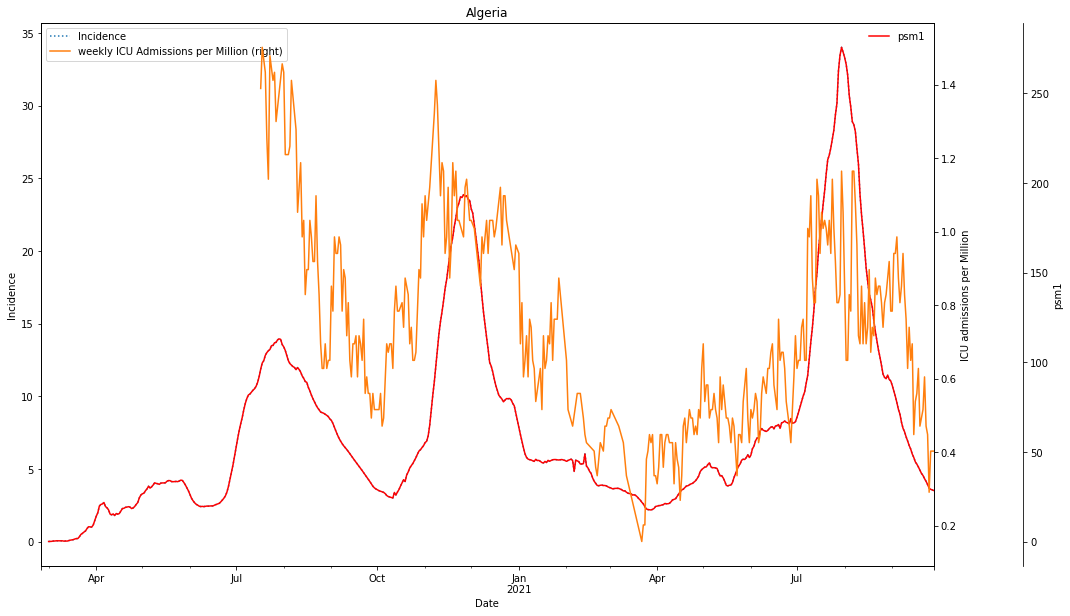

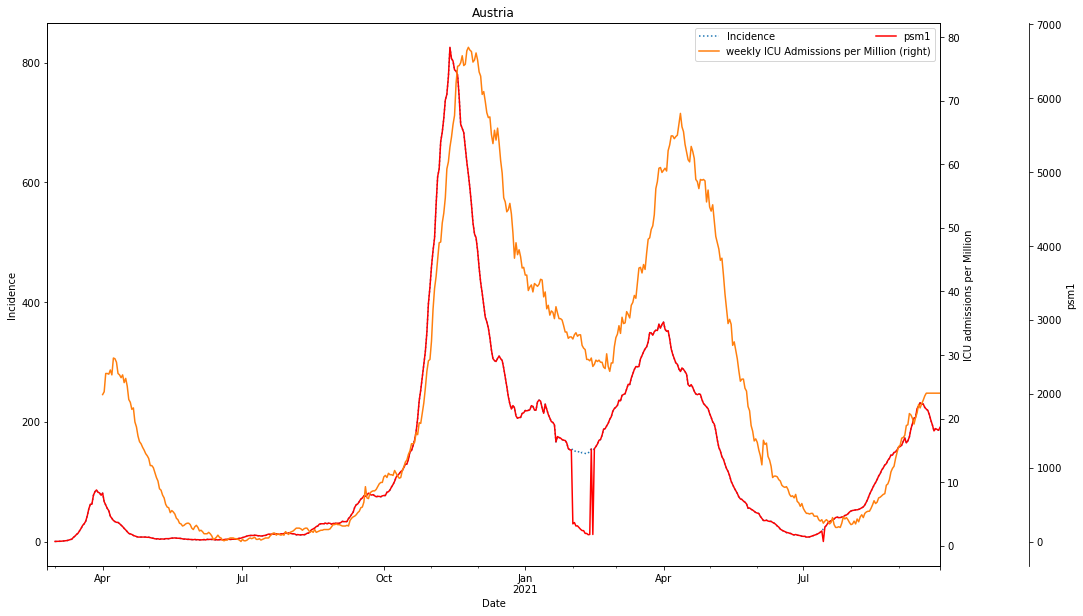

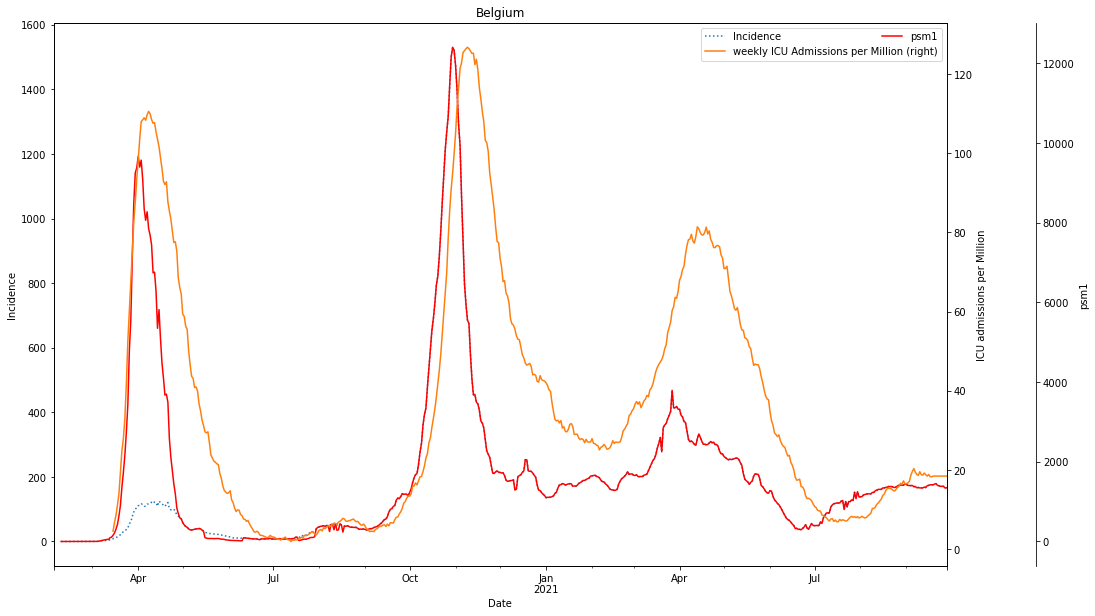

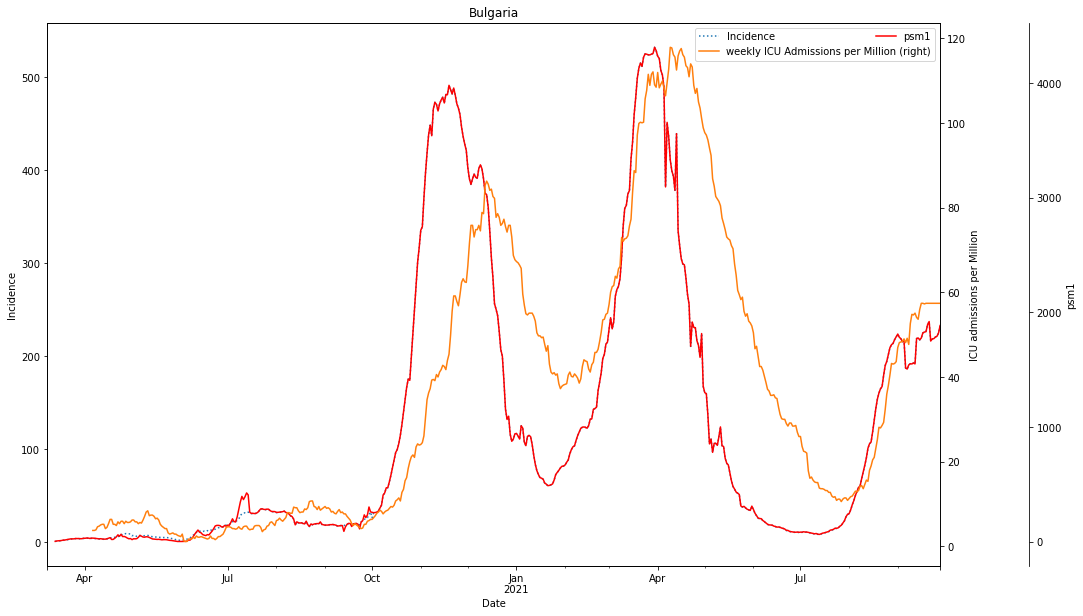

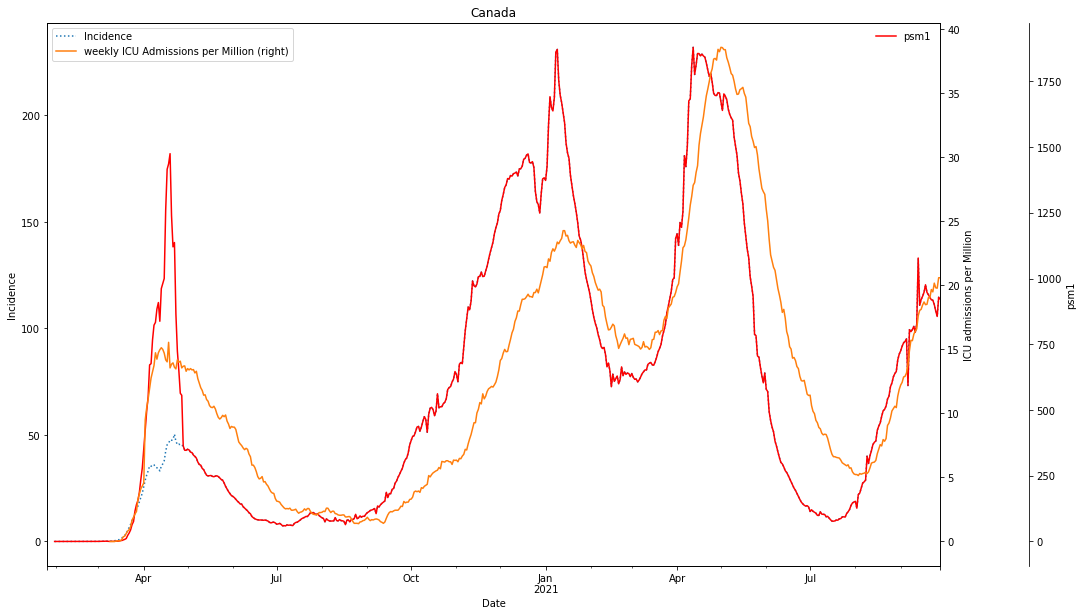

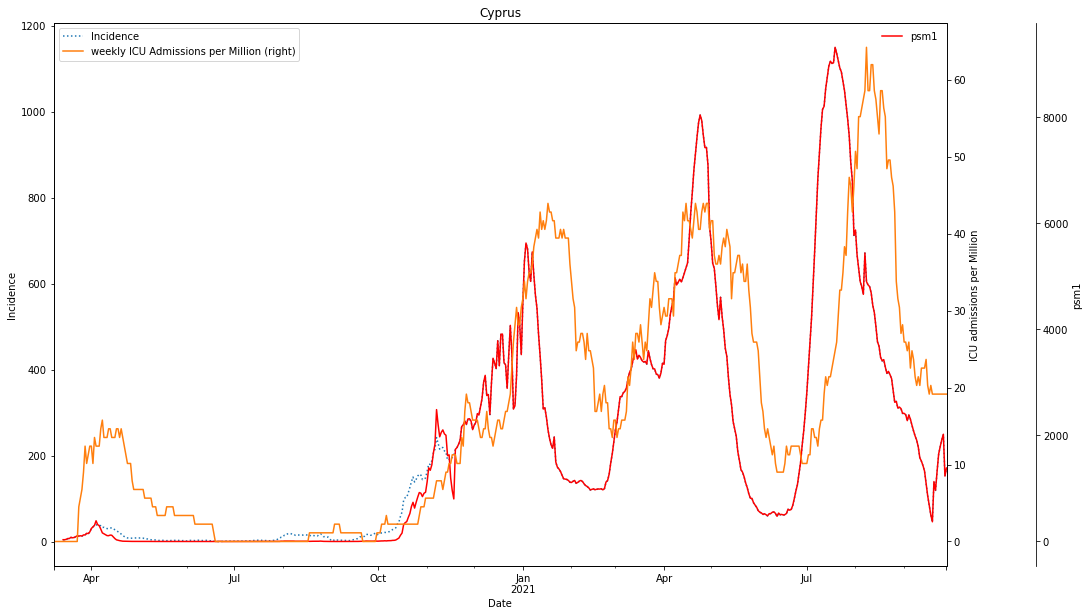

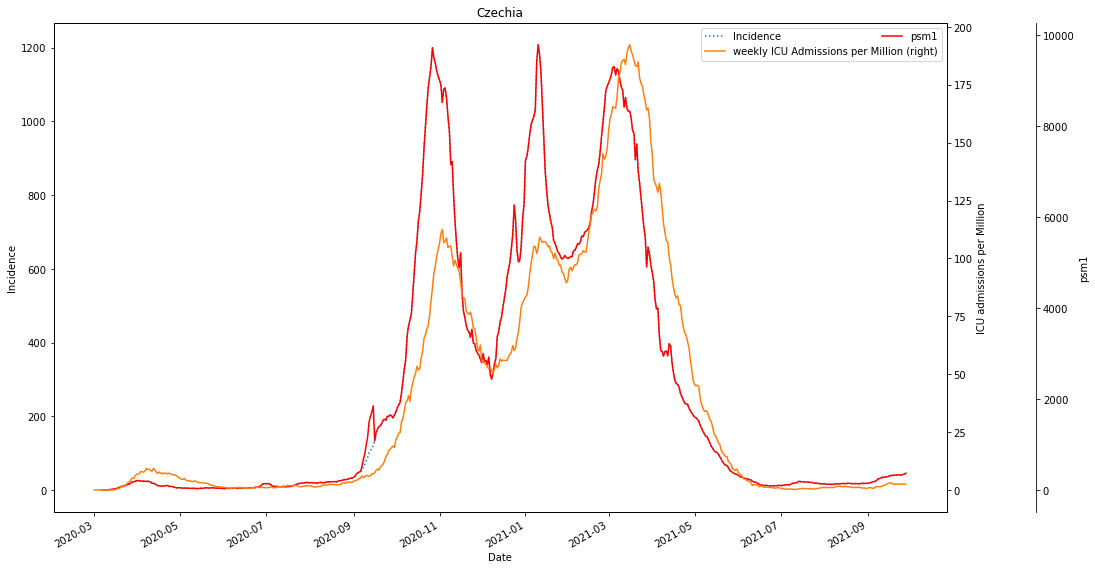

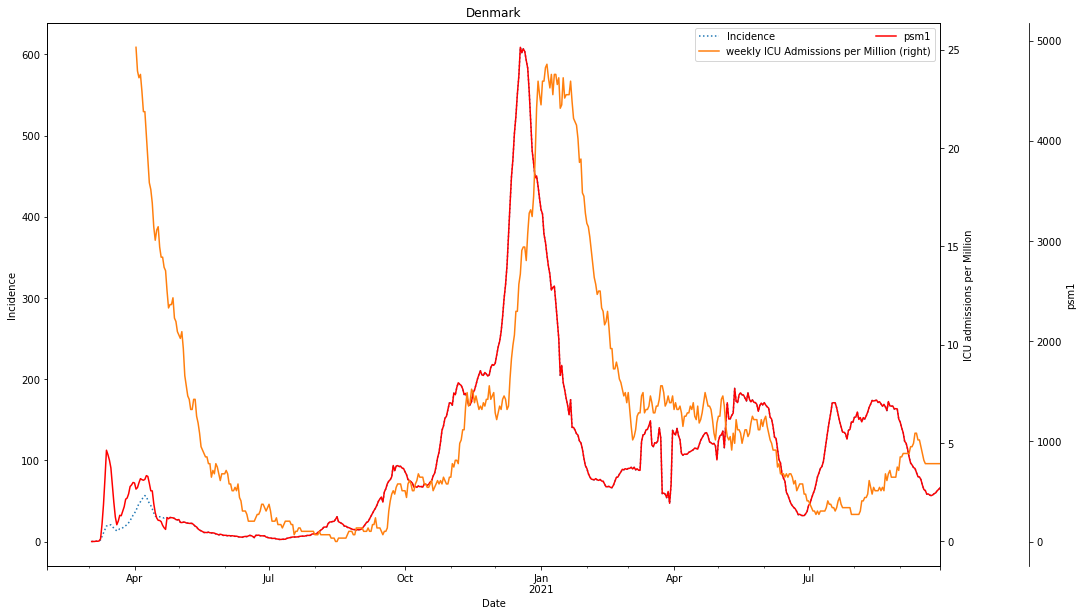

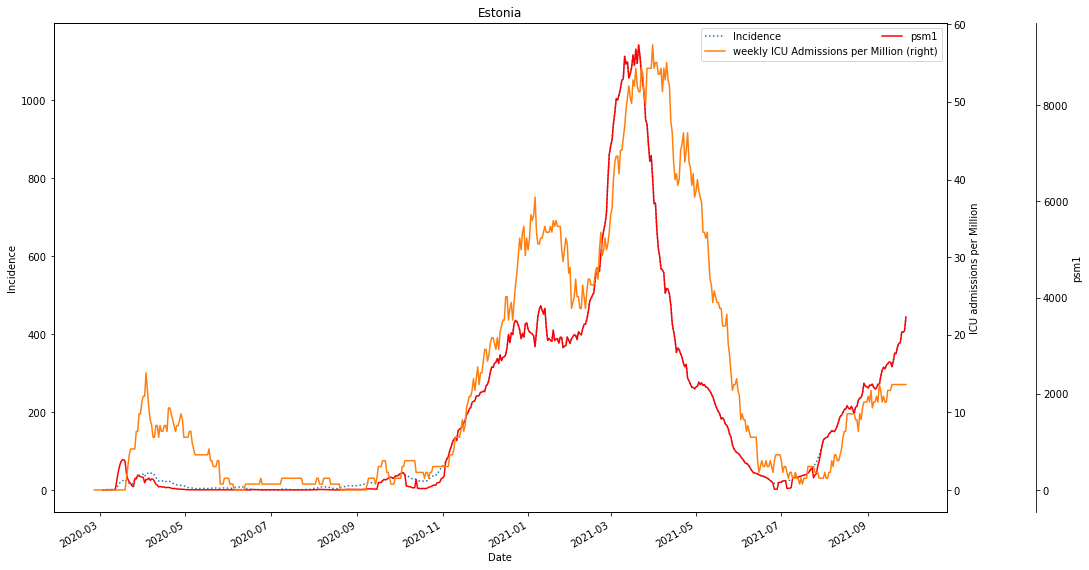

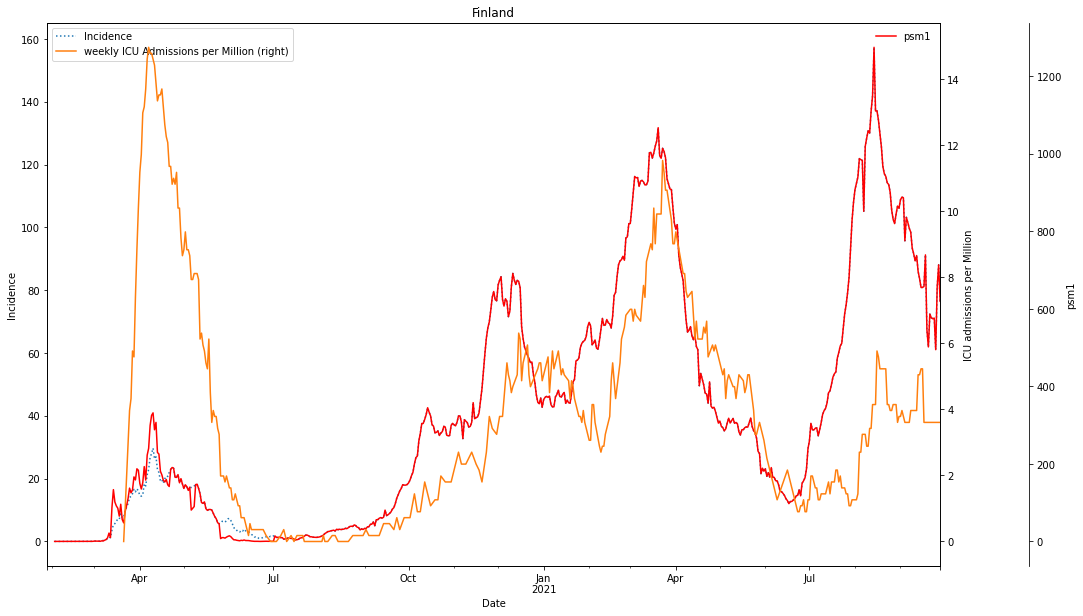

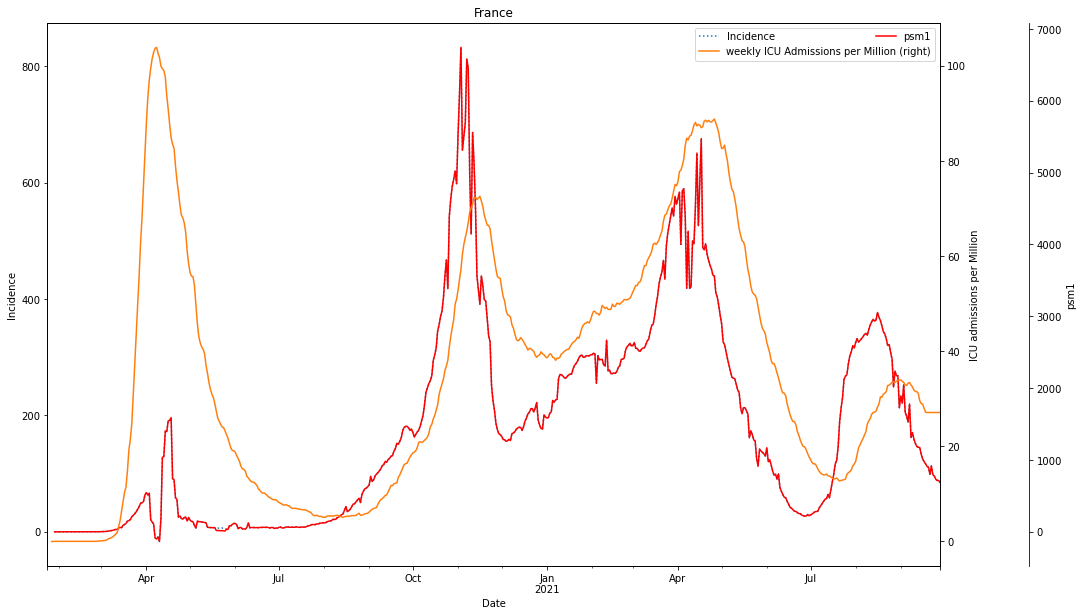

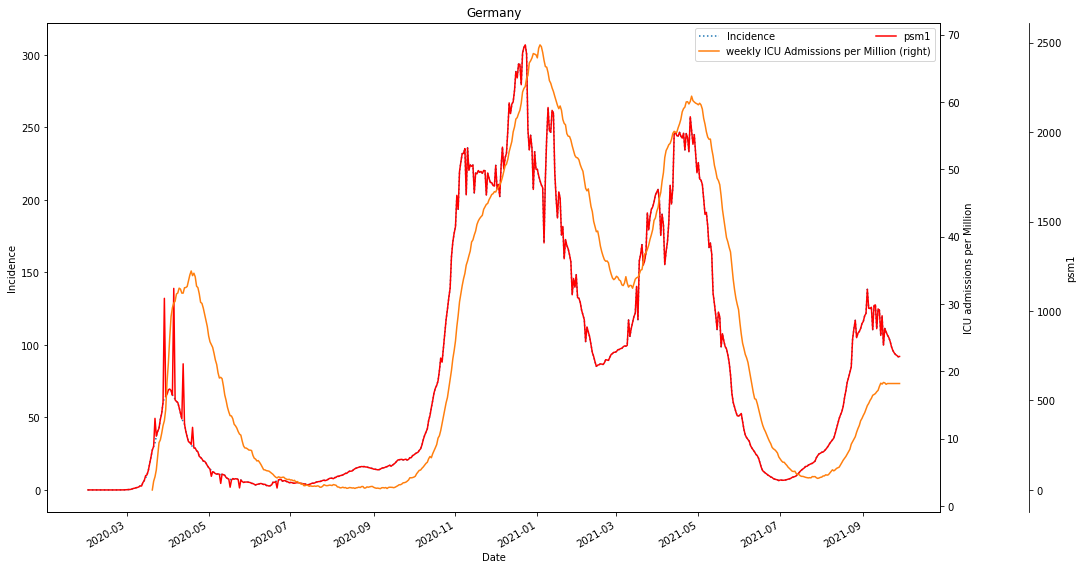

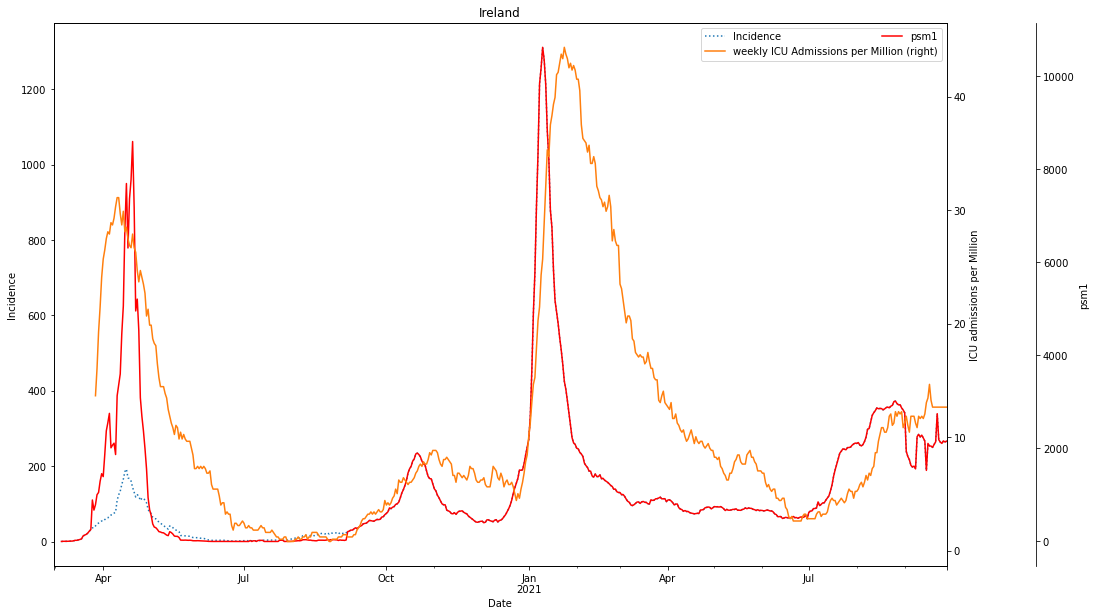

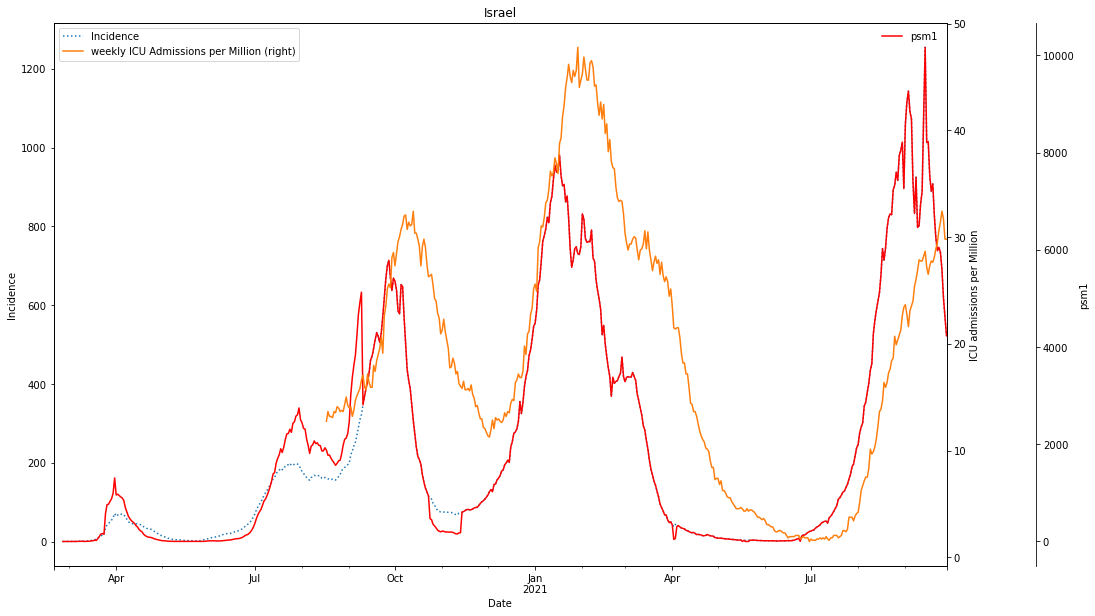

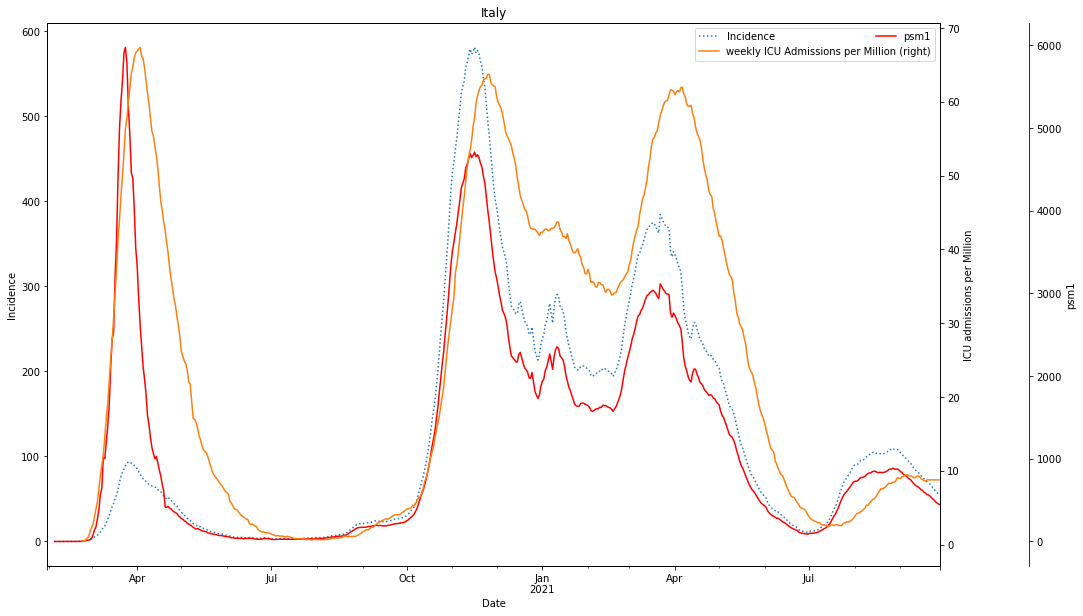

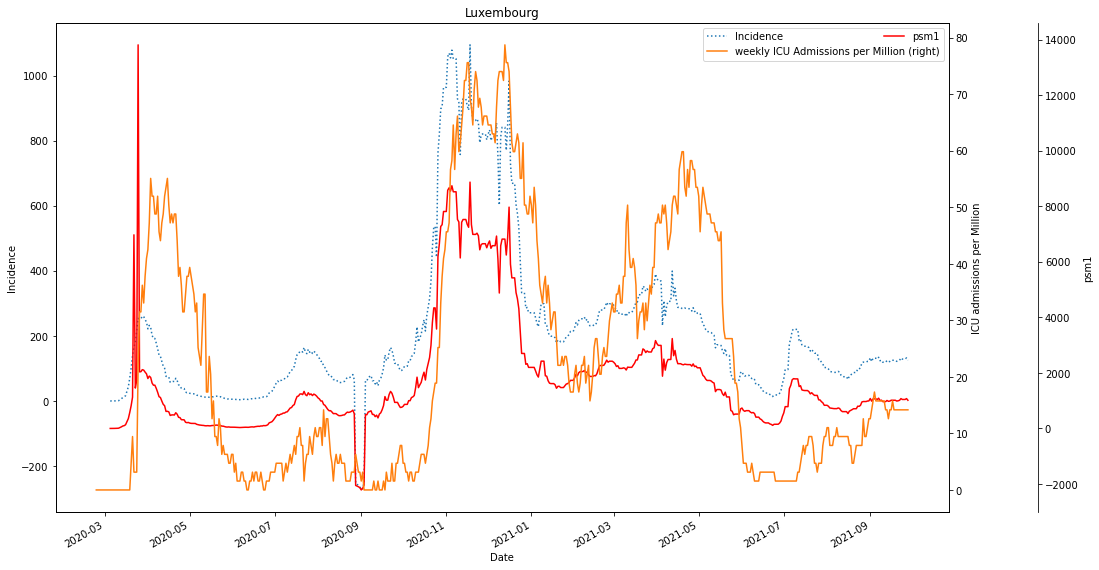

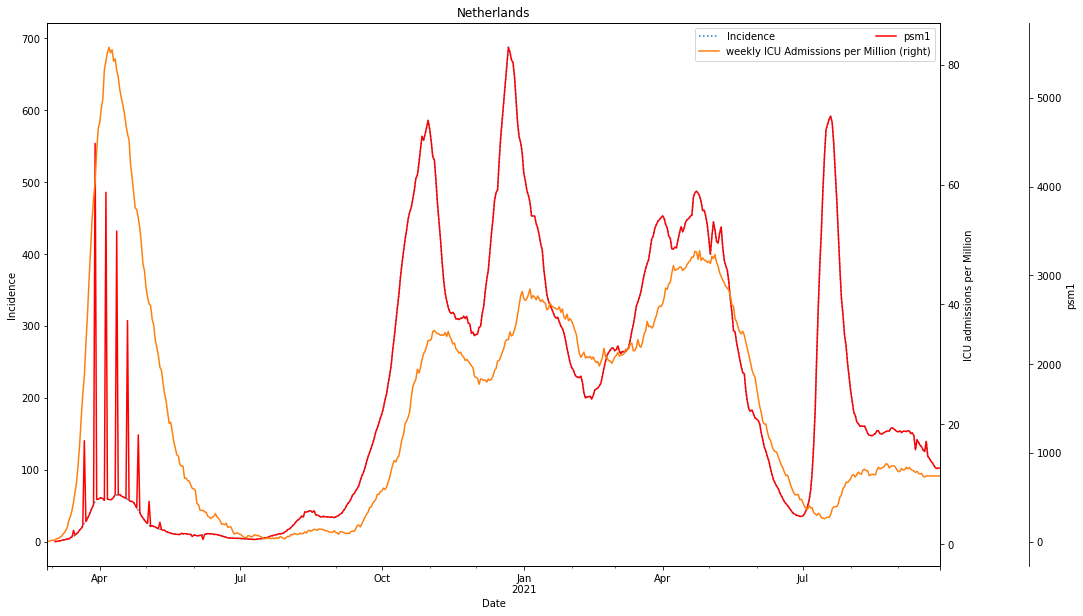

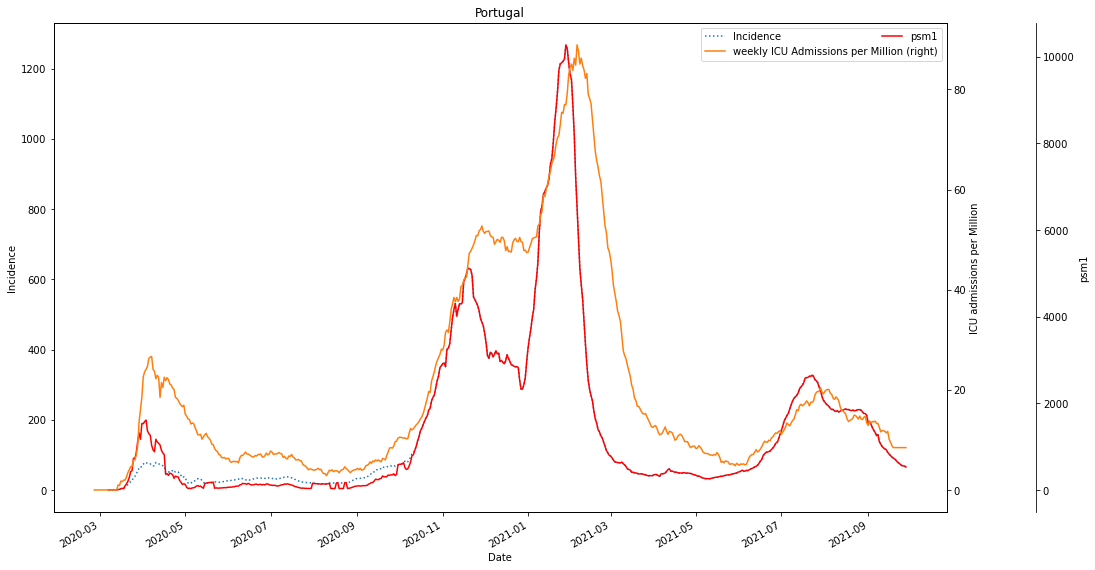

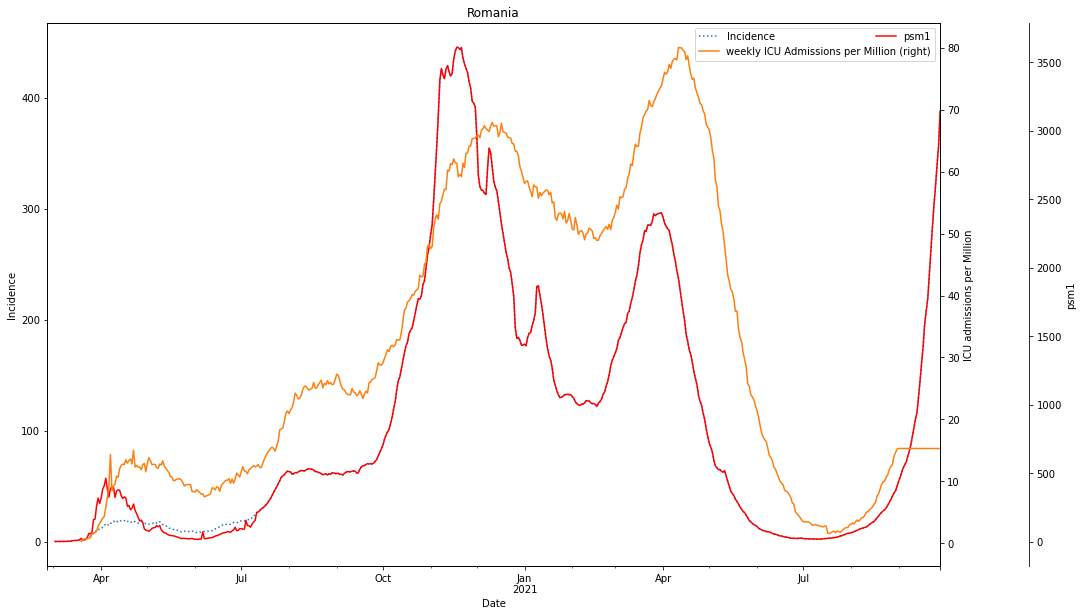

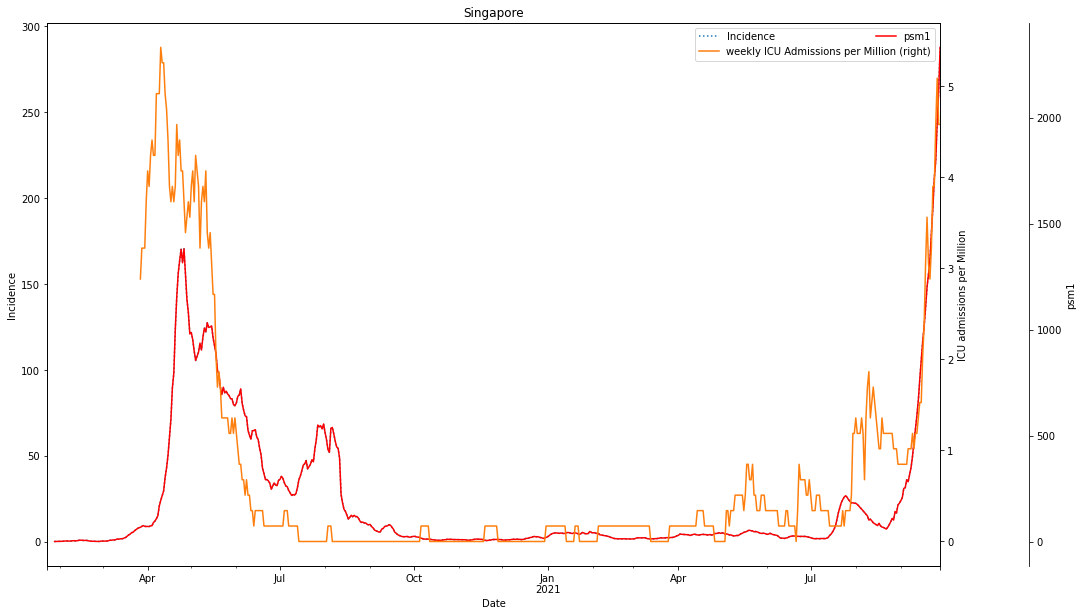

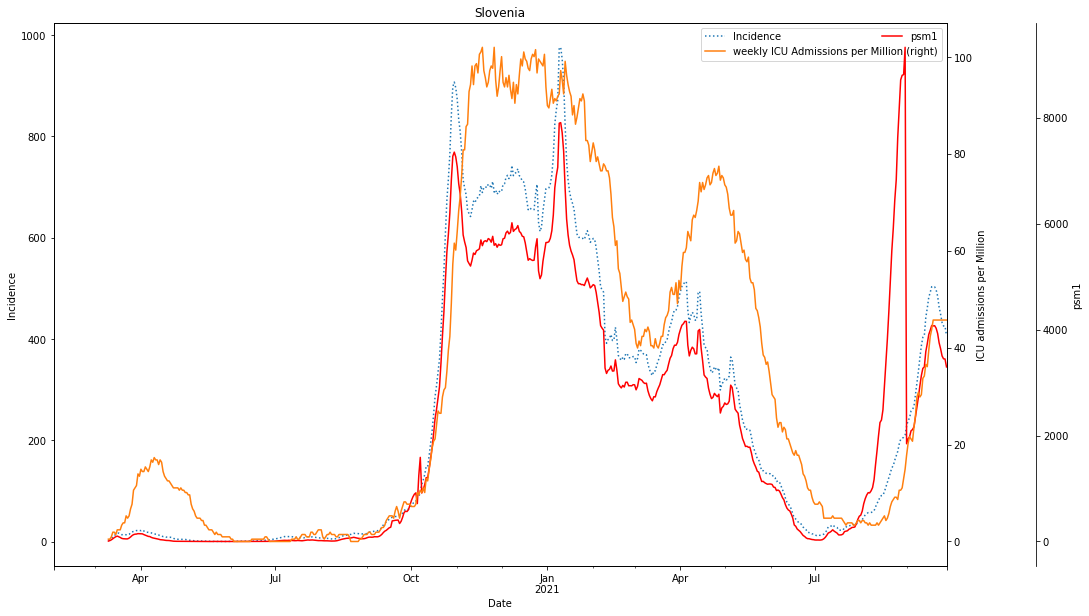

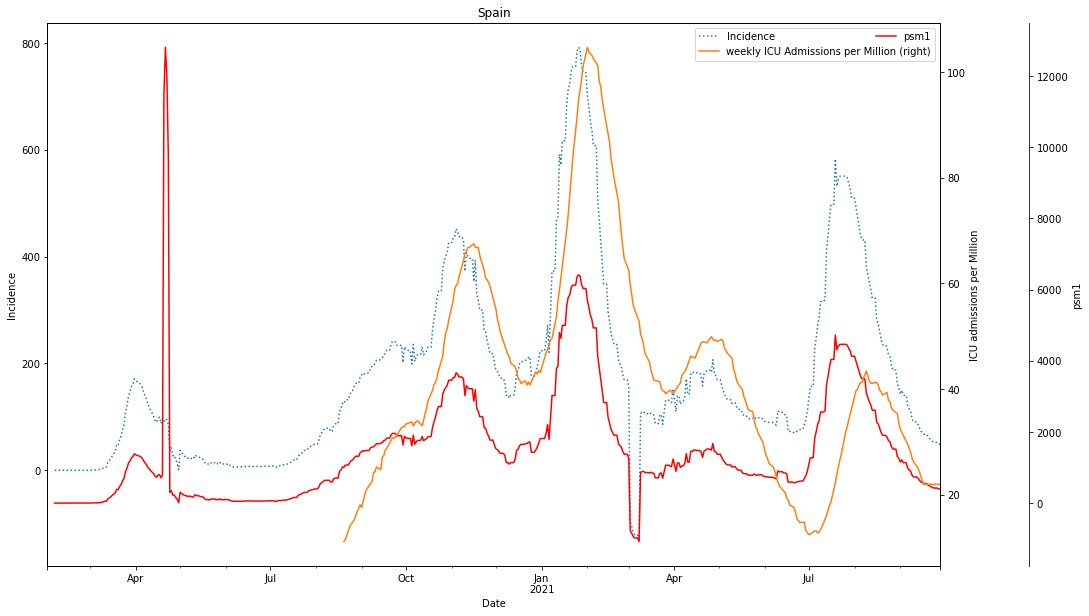

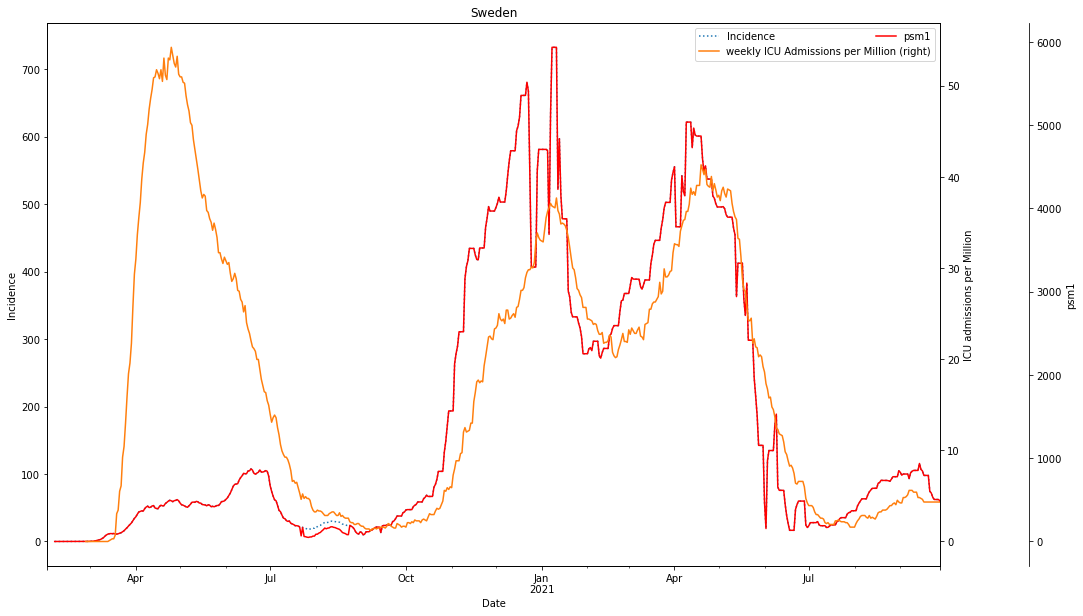

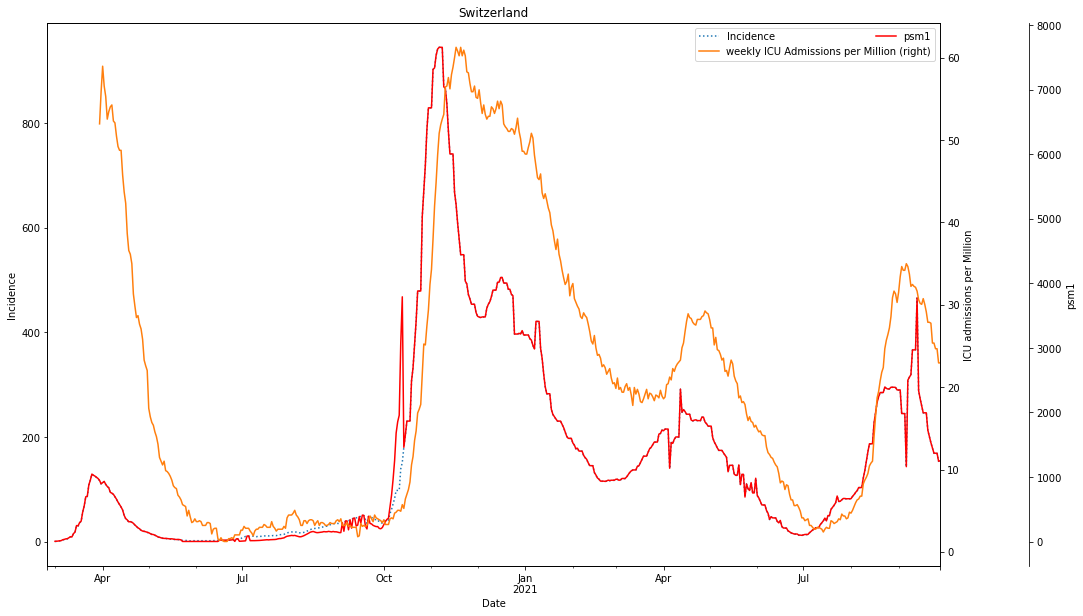

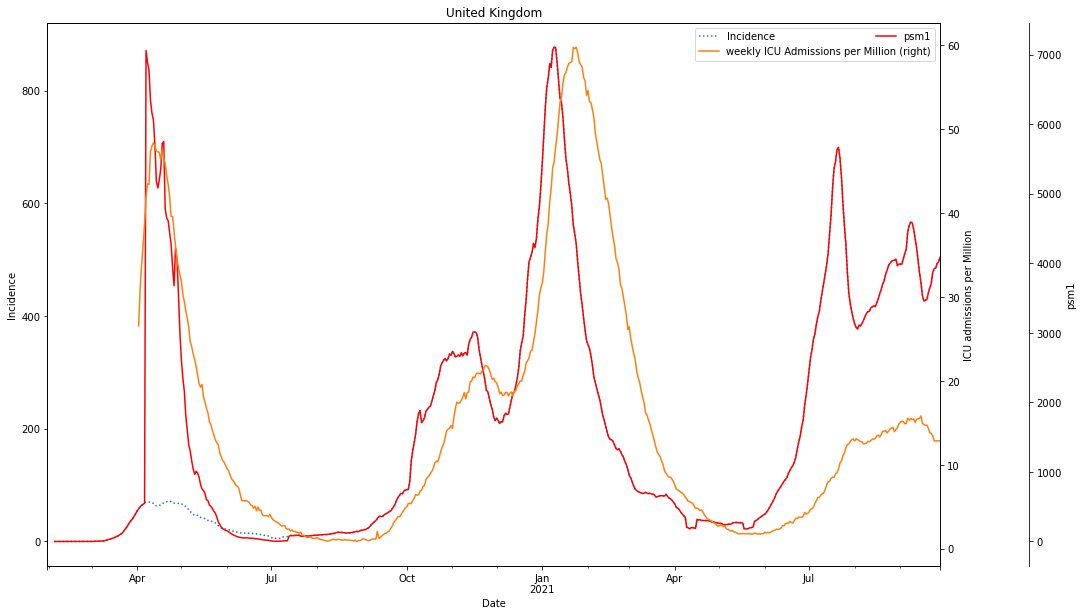

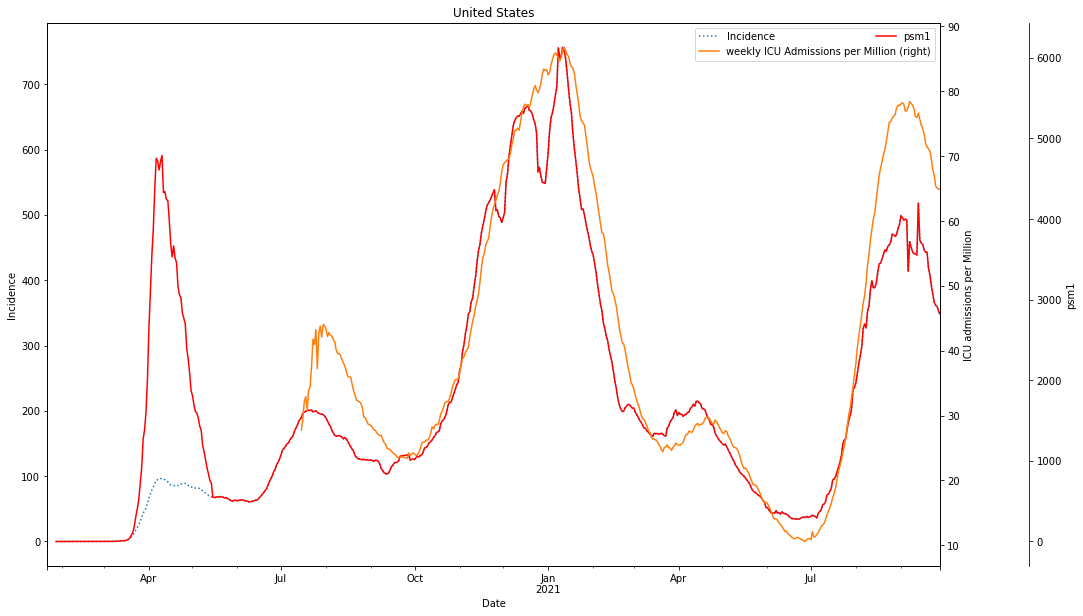

In [9]:
# Plot ICU Admissions, smoothed case numbers and positive rate

for country in icu_countries:
    df = cases_icu_grouped.get_group(country)
    # interpolate ICU occupancy linearly
    df.interpolate(method='linear', inplace=True)

    fig, ax = plt.subplots(figsize=(16,10))
    # for third variable
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.1))
    
    df.plot(x='date', y='new_cases_smoothed_per_million', kind='line', 
                  ylabel='Incidence', ax=ax, label='Incidence', linestyle='dotted')
    df.plot(x='date', y='icu_patients_per_million', kind='line', ax=ax,
            secondary_y=True, linestyle='solid',
           label='weekly ICU Admissions per Million')
    df.plot(x='date', y='psm1', kind='line', ax=ax2, color='red',
           label='psm1', ylabel='psm1')
    
    ax.set_title(str(df['location'].unique()[0]))
    ax.right_ax.set_ylabel('ICU admissions per Million')
    ax.set_xlabel('Date')
    ax2.legend(frameon=False)
    
    fig.savefig('./fig4paper/adjusted_incidence/adj_incidence_cases' + country + '.pdf', bbox_inches='tight')

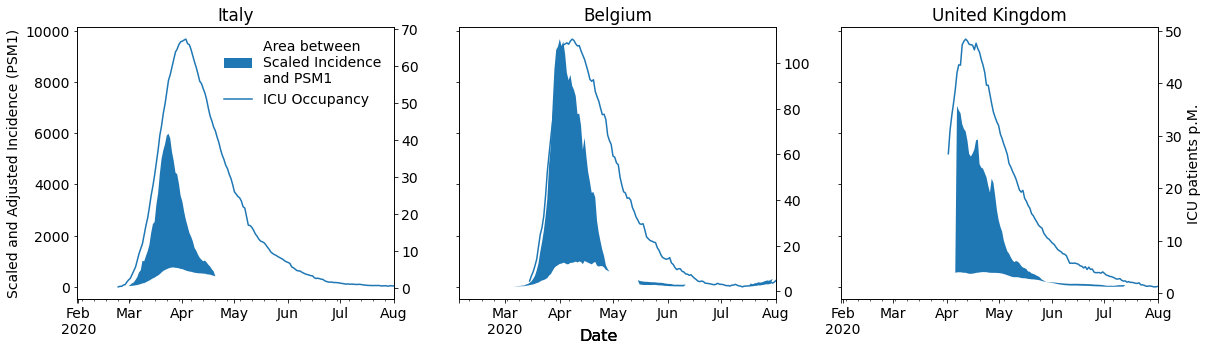

In [14]:
both_countries = ['Italy', 'Belgium', 'United Kingdom']

font = {'size': 14}
plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for i in range(len(both_countries)):
    
    country = both_countries[i]
    cax = ax[i]
    
    df = cases_icu_grouped.get_group(country)
    # interpolate ICU occupancy linearly
    df.interpolate(method='linear', inplace=True)

    # only consider first wave
    index_date = df.index[df.date > pd.to_datetime('2020-08-01')]
    df.drop(index_date, inplace=True)
    
    cax.fill_between(x=df.date, y1=df.psm1,
                     y2=df.new_cases_smoothed_per_million*baseline_factor,
                     label='Area between\nScaled Incidence\nand PSM1')
    cax.set_xlabel('')    
    keep_yaxis = copy(cax.yaxis)
            
    pandas_ax = df.plot(x='date', y='icu_patients_per_million', kind='line', ax=cax,
                        secondary_y=True, linestyle='solid',
                        label='ICU Occupancy', legend=False,
                        xlabel='')
    cax.yaxis = keep_yaxis
    
    if i == 0:
        handles, labels = cax.get_legend_handles_labels()
        pandas_h, pandas_l = pandas_ax.get_legend_handles_labels()
        handles.append(pandas_h[0])
        labels.append(pandas_l[0])
        plt.legend(handles, labels, frameon=False, ncol=1, loc='upper right')
    
    cax.set_title(str(df['location'].unique()[0]))
    cax.set_ylabel('Scaled and Adjusted Incidence (PSM1)')
    if i ==2:
        pandas_ax.set_ylabel('ICU patients p.M.')
    fig.text(0.48, 0.03, 'Date', fontsize=16)
    plt.tight_layout()

    
fig.savefig('./fig4paper/adjusted_incidence/first_waves_adjusted.pdf', bbox_inches='tight')
